In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cft
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import rc
rc('animation', html='html5')

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

import netCDF4 as nc
import datetime, time, os, sys
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
from netCDF4 import Dataset

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:33813 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 1 Memory: 4.00 GiB


This notebook creates a mask for wind to be used in the momentum equations in MoM. Specifically, this mask is used to change Velocity%smf in the MoM.

## Creating mask

The next two cells take data from a file known as topog.nc, which is an input in the MoM. We create a mask with the same dimensions and coordinates as present in topog.nc to maintain consistency.

In [4]:
nc_file = '/g/data/ik11/inputs/access-om2/input_20201102/mom_1deg/topog.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
topog_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
topog = topog_dataset.depth

nx, = topog.nx.shape
ny, = topog.ny.shape

nc_file = '/g/data/ik11/inputs/access-om2/input_20201102/mom_1deg/ocean_temp_salt.res.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
ocean_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))

x = ocean_dataset.GRID_X_T
y = ocean_dataset.GRID_Y_T
X, Y = np.meshgrid(x, y)

### Which one works?
(2, ny, nx) -> ✅

(2, nx, ny) -> ❌

(nx, ny, 2) -> ❌

(nx, 2, ny) -> ❌

(ny, nx, 2) -> ❌

(ny, 2, nx) -> ❌

In [5]:
# State the region where you would like to have winds

region = 'Southern Ocean and NADW region'
dy = 5
dx = 5

In [6]:
mask_array = np.ones(((ny, nx)))

#mask_tanh = xr.DataArray(mask_array,  coords = [y, x], dims = ['lat', 'lon'], name = 'mask', attrs = {'units':'none'})

#mask_da = xr.DataArray(mask_array,  coords = [topog.ny, topog.nx],  
#                           dims = ['ny', 'nx'], name = 'mask', attrs = {'units':'none'})

# Mask is performed and boundaries are treated with a tan hyperbolic function to reduce biases due to wind stress curl

if(region == 'everywhere'):
    mask_tanh = mask_array*1
    mask_da = xr.DataArray(mask_tanh, coords = [y, x], dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})
elif(region == 'none'):
    mask_tanh = mask_array*0
    mask_da = xr.DataArray(mask_tanh, coords = [y, x], dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})
elif(region == 'Southern Hemisphere'):
    y_max = 0
    mask_tanh = 0.5 * np.tanh((-Y + y_max)/dy) + 0.5
    mask_da = xr.DataArray(mask_tanh, coords = [y, x], dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})
elif(region == 'Northern Hemisphere'):
    y_max = 0
    mask_tanh = 0.5 * np.tanh((Y - y_max)/dy) + 0.5
    mask_da = xr.DataArray(mask_tanh, coords = [y, x], dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})
elif(region == 'Pacific Ocean'):
    y_min, y_max = 15, 60
    x_min, x_max = -250, -100
    mask_tanh = (0.5 * np.tanh((-Y + y_min)/dy) + 0.5) + (0.5 * np.tanh((Y - y_max)/dy) + 0.5)
    mask_da1 = xr.DataArray(mask_tanh, coords = [y, x], dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})
    
    mask_tanh = (0.5 * np.tanh((-X + x_min)/dx) + 0.5) + (0.5 * np.tanh((X - x_max)/dx) + 0.5)
    mask_da2 = xr.DataArray(mask_tanh, coords = [y, x], dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})
    
    mask_da = mask_da1 + mask_da2
    mask_da = mask_da.where(mask_da <= 1, 1)
elif(region == 'Southern Ocean and NADW region'):
    y_min, y_max = 0, 50
    mask_tanh = (0.5 * np.tanh((Y - y_max)/dy) + 0.5) + (0.5 * np.tanh((-Y + y_min)/dy) + 0.5)
    mask_da = xr.DataArray(mask_tanh, coords = [y, x], dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})

Text(0.5, 1.0, 'Latitudinal distribution of the wind stress mask')

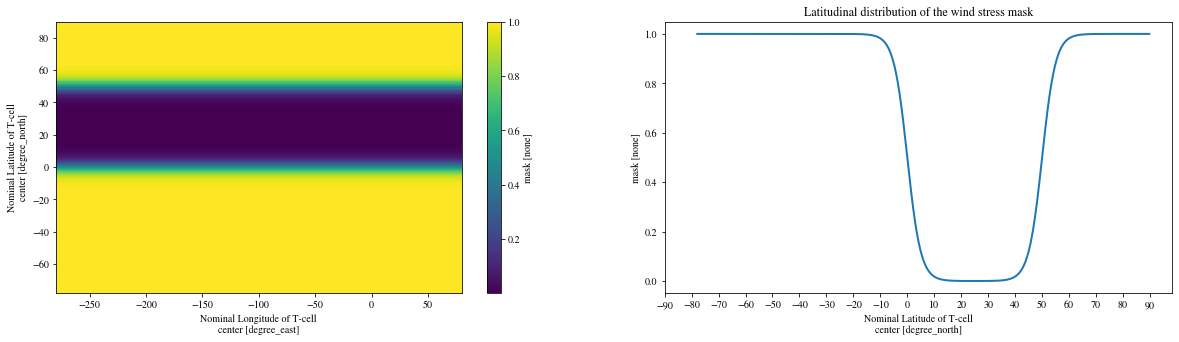

In [7]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))

mask_da.plot(ax = axes[0])
plt.title('Spatial distribution of the wind stress mask')

mask_da.sel(xu_ocean = -200, method = 'nearest').plot(ax = axes[1])
plt.xticks(np.linspace(-90, 90, 19))
plt.title('Latitudinal distribution of the wind stress mask')

In [8]:
mask_ds = mask_da.to_dataset()
mask_ds.to_netcdf(path = '/scratch/x77/db6174/1deg_inputs/stress_except_NANP/wind_mask.nc', mode = 'w', format = "NETCDF4", engine = "netcdf4")

## Extra stuff

In this section, we take wind data in x and y directions as inputs. Instead of creating a mask, these variables can be changed too. However, if we change them, the boundary layer depth will also feel the corresponding changes, which we do not want.

In [ ]:
nc_file = '/g/data/ik11/inputs/JRA-55/RYF/v1-4/RYF.uas.1990_1991.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
u_wind_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
uas = u_wind_dataset.uas

In [ ]:
nc_file = '/g/data/ik11/inputs/JRA-55/RYF/v1-4/RYF.vas.1990_1991.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
v_wind_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
vas = v_wind_dataset.vas

In [11]:
nc_file = '/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/ocean_temp_salt.res.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
grid_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
#grid = grid_dataset.depth